
# Metrics

## Data

### Close value

In [1]:
import sys

sys.path.append('..')

from util.graphs import plot_series
from timeseries.timeseries import StockMarketSeries
from timeseries.enums import SeriesColumn, DeviationSource, DeviationScale
from metrics.utils import MetricLevel, print_relation_results

company_name = "IBM"
time_series_start = "2017-01-03"
time_series_values = 1500
graph_size = 100
columns = [SeriesColumn.CLOSE]
stock = StockMarketSeries(company_name, time_series_start, time_series_values,
                          weights={SeriesColumn.OPEN: 0.2,
                                   SeriesColumn.CLOSE: 0.2,
                                   SeriesColumn.ADJ_CLOSE: 0.25,
                                   SeriesColumn.HIGH: 0.15,
                                   SeriesColumn.LOW: 0.15,
                                   SeriesColumn.VOLUME: 0.05},
                          all_noised_scale={DeviationScale.SLIGHTLY: 0.7,
                                            DeviationScale.MODERATELY: 3.0,
                                            DeviationScale.HIGHLY: 7.0},
                          all_incomplete_scale={DeviationScale.SLIGHTLY: 0.05,
                                                DeviationScale.MODERATELY: 0.12,
                                                DeviationScale.HIGHLY: 0.3},
                          all_obsolete_scale={DeviationScale.SLIGHTLY: 5,
                                              DeviationScale.MODERATELY: 15,
                                              DeviationScale.HIGHLY: 50},
                          partly_noised_scale={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 0.6,
                                                                    DeviationScale.MODERATELY: 2.0,
                                                                    DeviationScale.HIGHLY: 6.0},
                                               SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 0.4,
                                                                   DeviationScale.MODERATELY: 1.7,
                                                                   DeviationScale.HIGHLY: 5.2}},
                          partly_incomplete_scale={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 0.05,
                                                                        DeviationScale.MODERATELY: 0.12,
                                                                        DeviationScale.HIGHLY: 0.3},
                                                   SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 0.05,
                                                                       DeviationScale.MODERATELY: 0.12,
                                                                       DeviationScale.HIGHLY: 0.3}},
                          partly_obsolete_scale={SeriesColumn.CLOSE: {DeviationScale.SLIGHTLY: 5,
                                                                      DeviationScale.MODERATELY: 20,
                                                                      DeviationScale.HIGHLY: 50},
                                                 SeriesColumn.OPEN: {DeviationScale.SLIGHTLY: 3,
                                                                     DeviationScale.MODERATELY: 12,
                                                                     DeviationScale.HIGHLY: 30}})

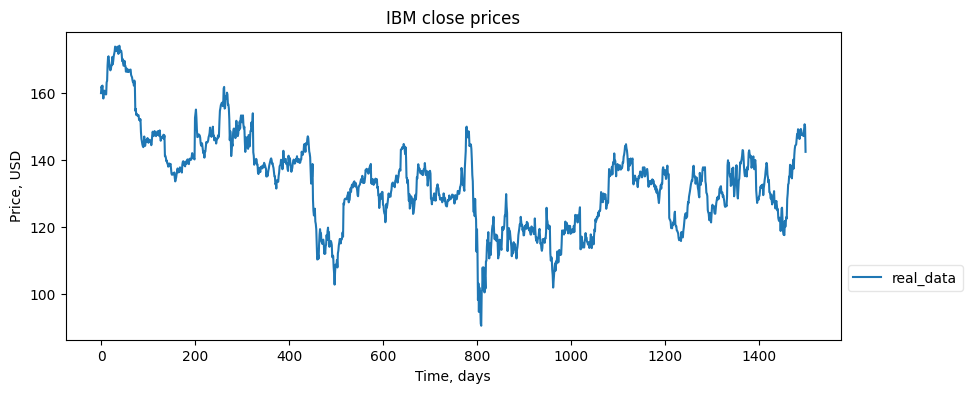

In [2]:
plot_series(stock, -1, "close prices", real_data=stock.real_series[SeriesColumn.CLOSE])

### Other values

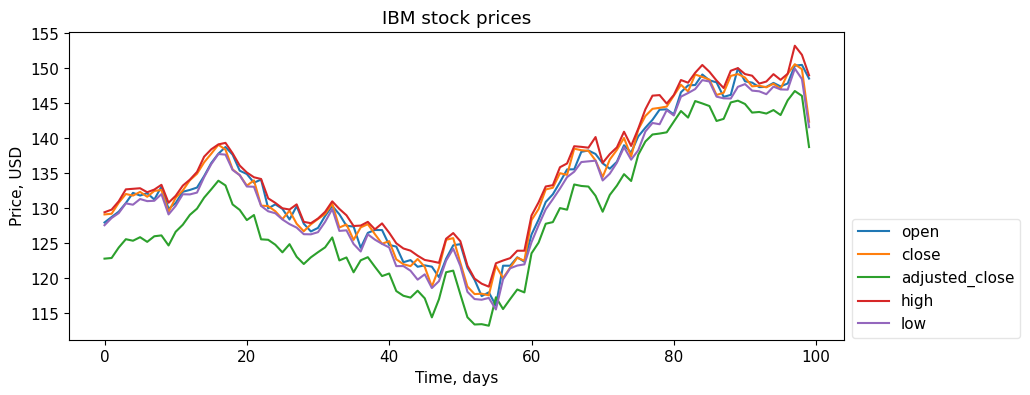

In [3]:
plot_series(stock, graph_size, "stock prices",
            open=stock.real_series[SeriesColumn.OPEN],
            close=stock.real_series[SeriesColumn.CLOSE],
            adjusted_close=stock.real_series[SeriesColumn.ADJ_CLOSE],
            high=stock.real_series[SeriesColumn.HIGH],
            low=stock.real_series[SeriesColumn.LOW])

## Correctness metric

### Show noise

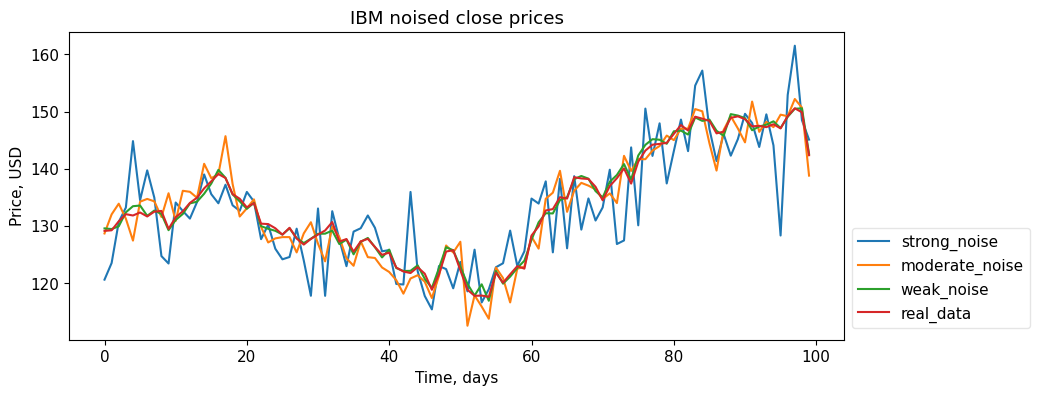

In [4]:
plot_series(stock, graph_size, "noised close prices",
            strong_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.HIGHLY][
                SeriesColumn.CLOSE],
            moderate_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.MODERATELY][
                SeriesColumn.CLOSE],
            weak_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][
                SeriesColumn.CLOSE],
            real_data=stock.real_series[SeriesColumn.CLOSE])

### Show Kalman filter

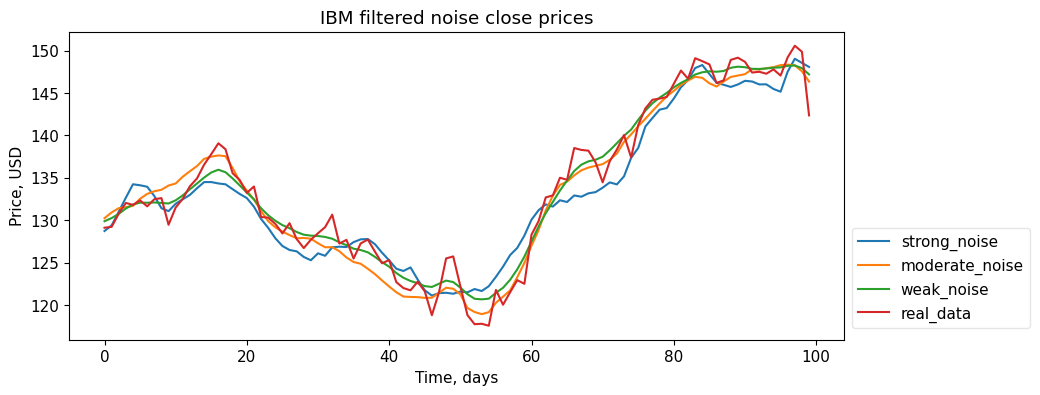

In [5]:
from timeseries.enums import MitigationType

plot_series(stock, graph_size, "filtered noise close prices",
            strong_noise=stock.mitigated_deviations_series[DeviationSource.NOISE][DeviationScale.HIGHLY][
                SeriesColumn.CLOSE][MitigationType.DATA],
            moderate_noise=stock.mitigated_deviations_series[DeviationSource.NOISE][DeviationScale.MODERATELY][
                SeriesColumn.CLOSE][MitigationType.DATA],
            weak_noise=stock.mitigated_deviations_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][
                SeriesColumn.CLOSE][MitigationType.DATA],
            real_data=stock.real_series[SeriesColumn.CLOSE])

### Heinrich's correctness metric on values

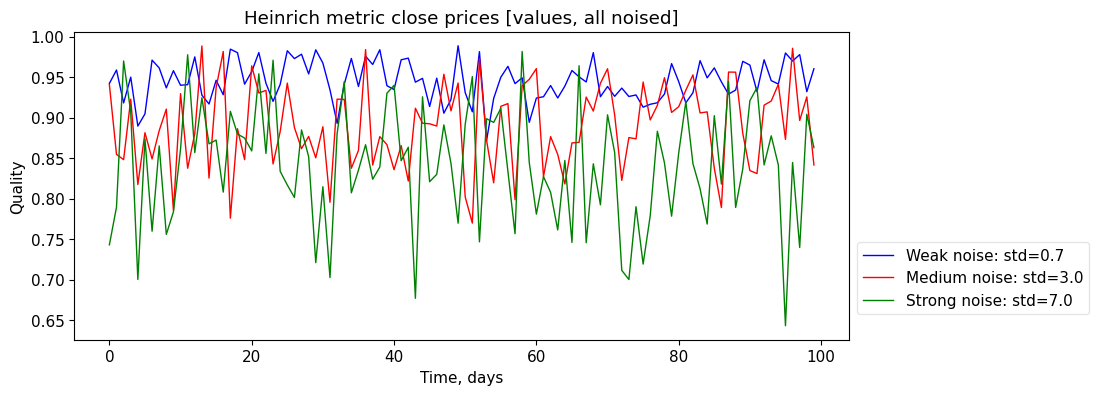

In [6]:
from correctness import HeinrichCorrectnessMetric
from timeseries.enums import DeviationRange

heinrich = HeinrichCorrectnessMetric(stock,
                                     alpha={SeriesColumn.OPEN: 1.6,
                                            SeriesColumn.CLOSE: 2.1,
                                            SeriesColumn.ADJ_CLOSE: 1.7,
                                            SeriesColumn.HIGH: 2.0,
                                            SeriesColumn.LOW: 2.3,
                                            SeriesColumn.VOLUME: 3.1})

qualities = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=False,
                                 column_name=SeriesColumn.CLOSE, graph_size=graph_size)

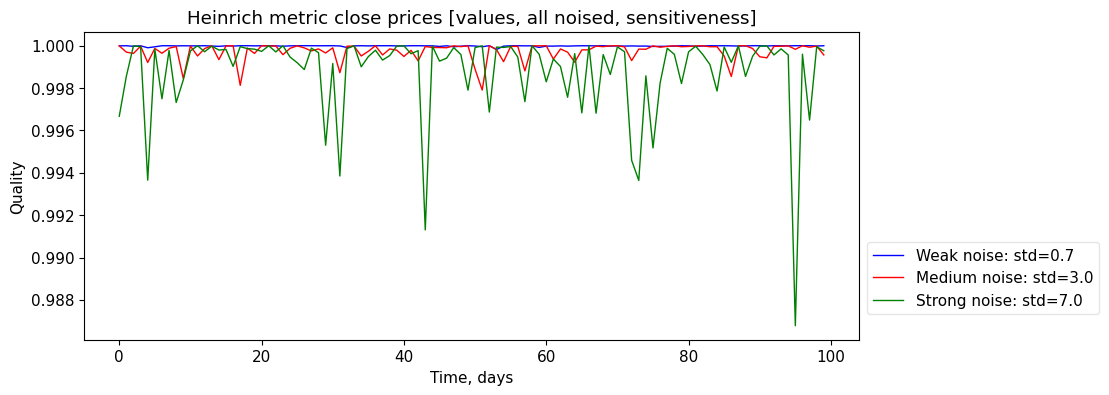

In [7]:
qualities = heinrich.values_qualities(SeriesColumn.CLOSE, is_alpha=True)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=True,
                                 column_name=SeriesColumn.CLOSE, graph_size=graph_size)

### Heinrich's correctness metric on tuples - all fields noised

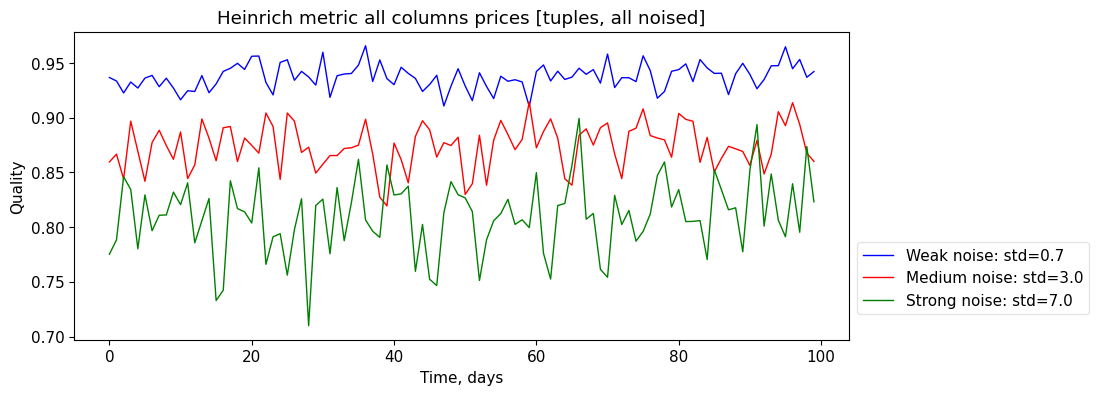

In [8]:
qualities = heinrich.tuples_qualities(DeviationRange.ALL, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.TUPLES, is_alpha=False, noise_range=DeviationRange.ALL, graph_size=graph_size)

### Heinrich's correctness metric on tuples - some fields noised

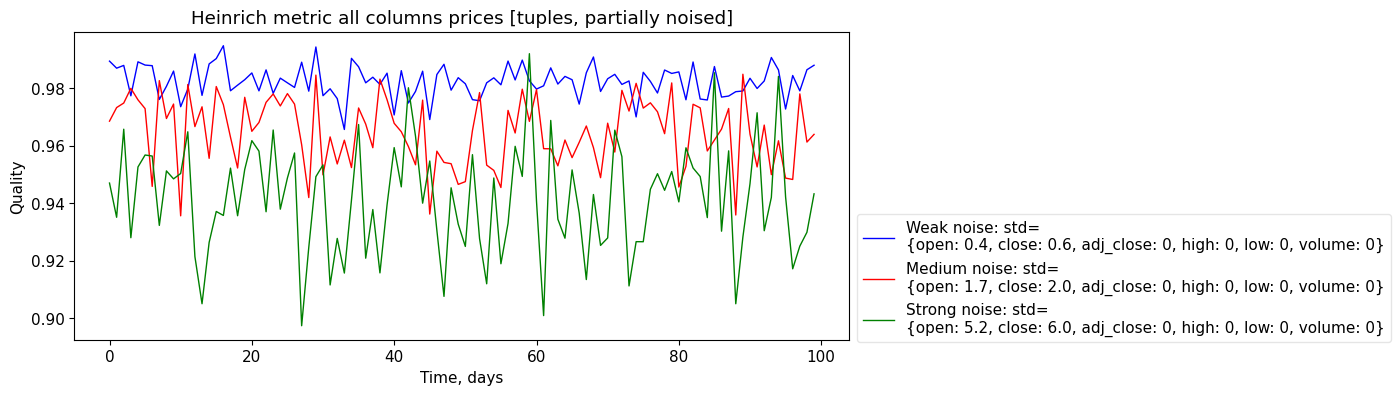

In [9]:
qualities = heinrich.tuples_qualities(DeviationRange.PARTIAL, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.TUPLES, is_alpha=False, noise_range=DeviationRange.PARTIAL, graph_size=graph_size)

### Heinrich's correctness metric on relation

In [10]:
qualities_close = heinrich.relation_qualities(DeviationRange.ALL, is_alpha=False, columns=columns)
print(print_relation_results(DeviationSource.NOISE, company_name, qualities_close, columns=columns))

Relation quality differences for noised series:
  Range       Scale Improve     Score
0   all    slightly       Y   0.91701
1   all    slightly       N  0.944853
2   all  moderately       Y  0.910189
3   all  moderately       N  0.886609
4   all      highly       Y  0.893428
5   all      highly       N  0.829887

\begin{tabular}{llll}
\toprule
Range &      Scale & Improve & Score \\
\midrule
  all &   slightly &       Y & 0.917 \\
  all &   slightly &       N & 0.945 \\
  all & moderately &       Y & 0.910 \\
  all & moderately &       N & 0.887 \\
  all &     highly &       Y & 0.893 \\
  all &     highly &       N & 0.830 \\
\bottomrule
\end{tabular}

None


C:\Users\Maciek\Desktop\Magisterka\project\metrics\..\metrics\utils.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = results.to_latex(index=False,


In [11]:
qualities_all = heinrich.relation_qualities(DeviationRange.ALL, is_alpha=False)
qualities_partial = heinrich.relation_qualities(DeviationRange.PARTIAL, is_alpha=False)
print_relation_results(DeviationSource.NOISE, company_name, qualities_all, qualities_partial)

Relation quality differences for noised series:
        Range       Scale Improve     Score
0         all    slightly       Y  0.902877
1         all    slightly       N  0.937485
2         all  moderately       Y  0.895979
3         all  moderately       N  0.873117
4         all      highly       Y   0.87524
5         all      highly       N   0.80896
6   partially    slightly       Y   0.96716
7   partially    slightly       N  0.981861
8   partially  moderately       Y   0.96438
9   partially  moderately       N   0.96469
10  partially      highly       Y  0.956572
11  partially      highly       N  0.938736

\begin{tabular}{llll}
\toprule
    Range &      Scale & Improve & Score \\
\midrule
      all &   slightly &       Y & 0.903 \\
      all &   slightly &       N & 0.937 \\
      all & moderately &       Y & 0.896 \\
      all & moderately &       N & 0.873 \\
      all &     highly &       Y & 0.875 \\
      all &     highly &       N & 0.809 \\
partially &   slightly &       

C:\Users\Maciek\Desktop\Magisterka\project\metrics\..\metrics\utils.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = results.to_latex(index=False,


## Completeness metrics

### Show incompleteness

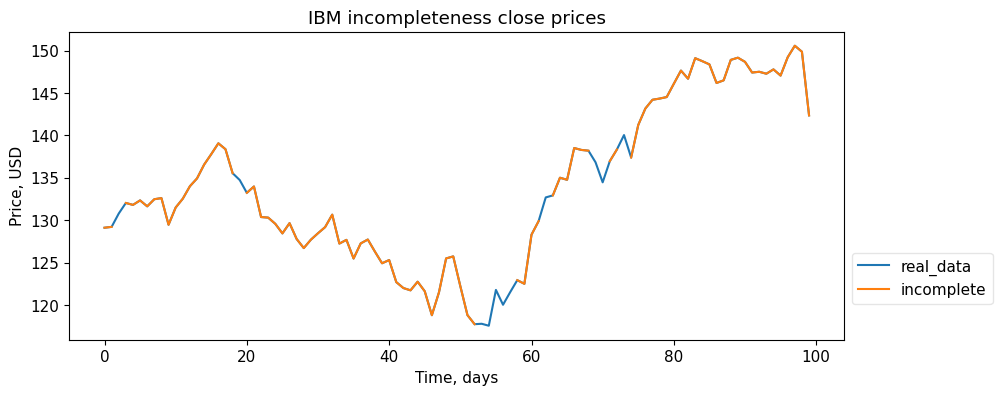

In [12]:
plot_series(stock, graph_size, "incompleteness close prices",
            real_data=stock.real_series[SeriesColumn.CLOSE],
            incomplete=stock.all_deviated_series[DeviationSource.INCOMPLETENESS]
            [DeviationScale.MODERATELY][SeriesColumn.CLOSE])

### Show interpolated values

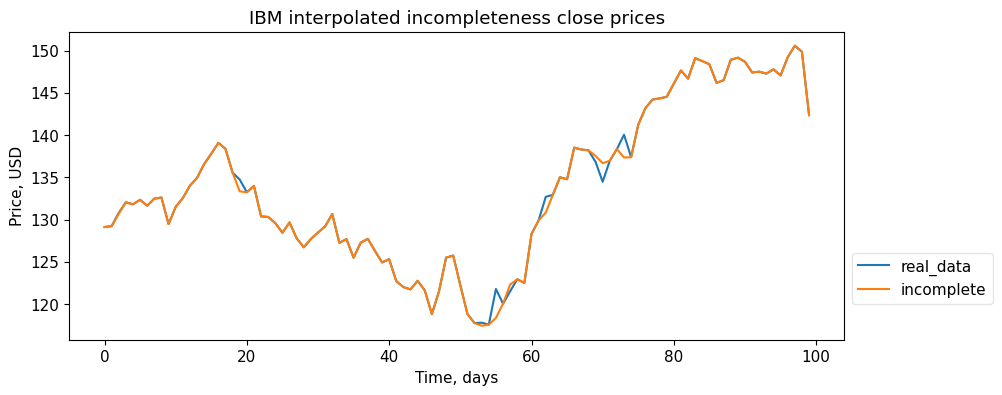

In [13]:
plot_series(stock, graph_size, "interpolated incompleteness close prices",
            real_data=stock.real_series[SeriesColumn.CLOSE],
            incomplete=stock.mitigated_deviations_series[DeviationSource.INCOMPLETENESS]
            [DeviationScale.MODERATELY][SeriesColumn.CLOSE][MitigationType.DATA])

### Blake's completeness metric on values

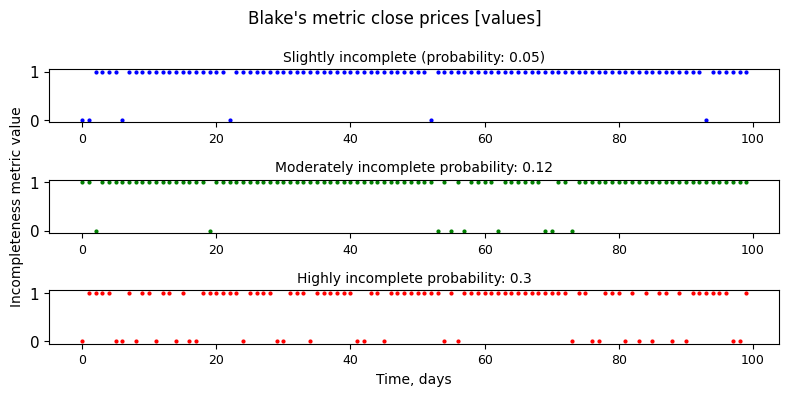

In [14]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities = blake.values_qualities(SeriesColumn.CLOSE)
blake.draw_blake(qualities, MetricLevel.VALUES, column_name=SeriesColumn.CLOSE, graph_size=graph_size)

### Blake's completeness metric on tuples - all columns affected

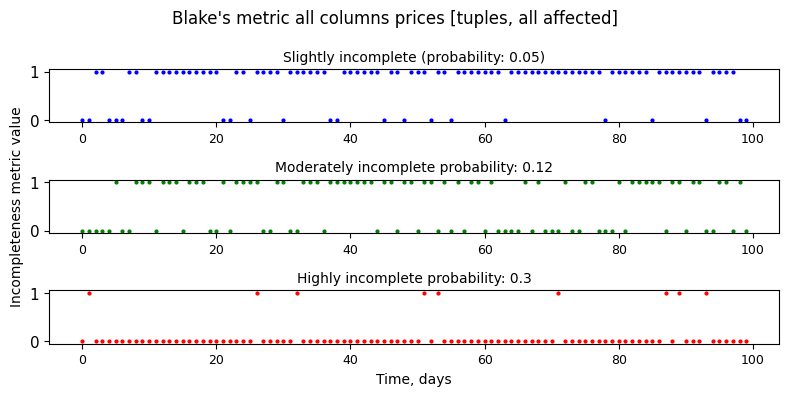

In [15]:
qualities = blake.tuples_qualities(incompleteness_range=DeviationRange.ALL)
blake.draw_blake(qualities, MetricLevel.TUPLES, incompleteness_range=DeviationRange.ALL, graph_size=graph_size)

### Blake's completeness metric on tuples - some columns affected

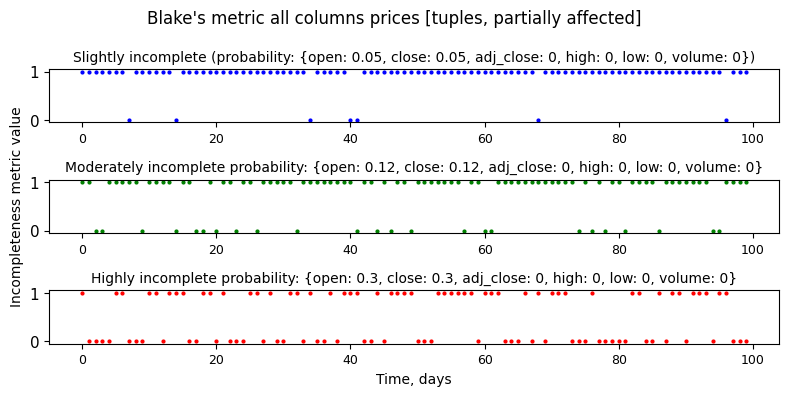

In [16]:
qualities = blake.tuples_qualities(incompleteness_range=DeviationRange.PARTIAL)
blake.draw_blake(qualities, MetricLevel.TUPLES, incompleteness_range=DeviationRange.PARTIAL, graph_size=graph_size)

### Blake's completeness metric on relation

In [17]:
qualities_close = blake.relation_qualities(incompleteness_range=DeviationRange.ALL, columns=columns)
print_relation_results(DeviationSource.INCOMPLETENESS, company_name, qualities_close, columns=columns)

Relation quality differences for incomplete series:
  Range       Scale Improve     Score
0   all    slightly       Y       1.0
1   all    slightly       N  0.950667
2   all  moderately       Y       1.0
3   all  moderately       N      0.89
4   all      highly       Y       1.0
5   all      highly       N  0.705333

\begin{tabular}{llll}
\toprule
Range &      Scale & Improve & Score \\
\midrule
  all &   slightly &       Y & 1.000 \\
  all &   slightly &       N & 0.951 \\
  all & moderately &       Y & 1.000 \\
  all & moderately &       N & 0.890 \\
  all &     highly &       Y & 1.000 \\
  all &     highly &       N & 0.705 \\
\bottomrule
\end{tabular}



C:\Users\Maciek\Desktop\Magisterka\project\metrics\..\metrics\utils.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = results.to_latex(index=False,


In [18]:
qualities_all = blake.relation_qualities(incompleteness_range=DeviationRange.ALL)
qualities_partial = blake.relation_qualities(incompleteness_range=DeviationRange.PARTIAL)
print_relation_results(DeviationSource.INCOMPLETENESS, company_name, qualities_all, qualities_partial)

Relation quality differences for incomplete series:
        Range       Scale Improve     Score
0         all    slightly       Y       1.0
1         all    slightly       N     0.734
2         all  moderately       Y       1.0
3         all  moderately       N  0.471333
4         all      highly       Y       1.0
5         all      highly       N  0.121333
6   partially    slightly       Y       1.0
7   partially    slightly       N     0.886
8   partially  moderately       Y       1.0
9   partially  moderately       N  0.773333
10  partially      highly       Y       1.0
11  partially      highly       N  0.501333

\begin{tabular}{llll}
\toprule
    Range &      Scale & Improve & Score \\
\midrule
      all &   slightly &       Y & 1.000 \\
      all &   slightly &       N & 0.734 \\
      all & moderately &       Y & 1.000 \\
      all & moderately &       N & 0.471 \\
      all &     highly &       Y & 1.000 \\
      all &     highly &       N & 0.121 \\
partially &   slightly &   

C:\Users\Maciek\Desktop\Magisterka\project\metrics\..\metrics\utils.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = results.to_latex(index=False,


## Timeliness metric

### Timeliness metric on values

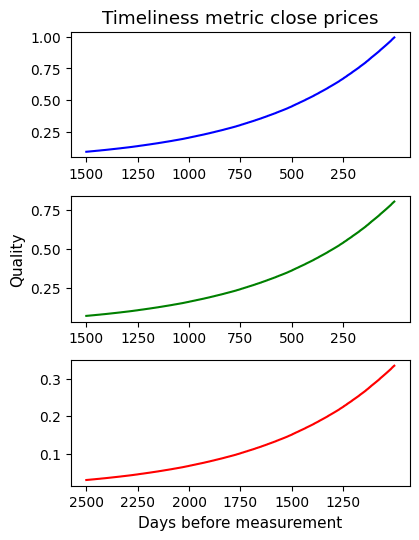

In [19]:
from metrics.timeliness import HeinrichTimelinessMetric

declines = {SeriesColumn.OPEN: 0.4,
            SeriesColumn.CLOSE: 0.4,
            SeriesColumn.ADJ_CLOSE: 0.3,
            SeriesColumn.HIGH: 0.4,
            SeriesColumn.LOW: 0.4,
            SeriesColumn.VOLUME: 0.7}

measurement_times = {DeviationScale.SLIGHTLY: 5,
                     DeviationScale.MODERATELY: 200,
                     DeviationScale.HIGHLY: 1000}

timeliness = HeinrichTimelinessMetric(stock, declines, measurement_times)
time_deltas, qualities = timeliness.values_qualities(SeriesColumn.CLOSE)
timeliness.draw_timeliness_qualities(time_deltas, qualities, SeriesColumn.CLOSE)

### Timeliness metric on tuples

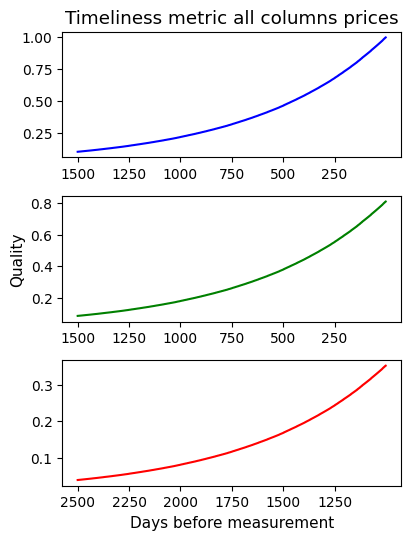

In [20]:
time_deltas, qualities = timeliness.tuples_qualities(obsoleteness_range=DeviationRange.ALL)
timeliness.draw_timeliness_qualities(time_deltas, qualities)

### Timeliness metric on relation

In [21]:
qualities_close = timeliness.relation_qualities(DeviationRange.ALL)
print_relation_results(DeviationSource.TIMELINESS, company_name, qualities_close, columns=columns)

Relation quality differences for obsolete series:
  Range       Scale Improve     Score
0   all    slightly       N  0.393751
1   all  moderately       N  0.321735
2   all      highly       N  0.142364

\begin{tabular}{llll}
\toprule
Range &      Scale & Improve & Score \\
\midrule
  all &   slightly &       N & 0.394 \\
  all & moderately &       N & 0.322 \\
  all &     highly &       N & 0.142 \\
\bottomrule
\end{tabular}



C:\Users\Maciek\Desktop\Magisterka\project\metrics\..\metrics\utils.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = results.to_latex(index=False,


In [22]:
qualities_all = timeliness.relation_qualities(DeviationRange.ALL)
qualities_partial = timeliness.relation_qualities(DeviationRange.PARTIAL)
print_relation_results(DeviationSource.TIMELINESS, company_name, qualities_all, qualities_partial)

Relation quality differences for obsolete series:
       Range       Scale Improve     Score
0        all    slightly       N  0.393751
1        all  moderately       N  0.321735
2        all      highly       N  0.142364
3  partially    slightly       N  0.394982
4  partially  moderately       N  0.366176
5  partially      highly       N  0.294427

\begin{tabular}{llll}
\toprule
    Range &      Scale & Improve & Score \\
\midrule
      all &   slightly &       N & 0.394 \\
      all & moderately &       N & 0.322 \\
      all &     highly &       N & 0.142 \\
partially &   slightly &       N & 0.395 \\
partially & moderately &       N & 0.366 \\
partially &     highly &       N & 0.294 \\
\bottomrule
\end{tabular}



C:\Users\Maciek\Desktop\Magisterka\project\metrics\..\metrics\utils.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = results.to_latex(index=False,
